# Матчинг изображений с описанием

## Введение


Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.
Необходимо разработать модель. поиска референсных фотографий для фотографов.

Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое:
⎢ A man is crossing a mountain pass on a metal bridge.
Сервис выводит несколько фотографий с такой же или похожей сценой.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим.

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.
На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

**Юридические ограничения**

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.






## Описание работы

Шаг 1. Загрузка данныч и исследовательский анализ


Шаг 2. Подготовка данных к обучению модели:

- Создать список слов которые, могут попадать под юридические ограничения.
- Исключить из обучающего датасета пары, которые, исходя из подготовленного вами списка слов, могут попадать под юридические ограничения.
- Векторизация текстового описания  методом BERT.
- Векторизация изображений с использованием модели ResNet50 из библиотеки PyTorch.


Шаг 3. Обучение модели

Создадим модель, которая покажет близость двух векторов. Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов.

Оценку точности различных моделей будем проводить Метрикой RMSE и на финальной стадии метрикой для классификации - Recall, чтобы оценить как точно модель подобрала изображение.

Для моделей будем подбирать гиперпараметры. В качестве моделей обязательно нужно рассмотреть:

1. Линейную регрессию;
2. Полносвязные нейронные сети.

Шаг 4. Тестирование модели и демонстрация ее работы
Тестирование лучшей модели будем проводить на тестовых данных.

Для этого создадим функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.

💡 Если запрос ведёт на юридически вредный контент, функция должна выводить дисклеймер.

С помощью этой функции работа модели
будет протестирована на нескольких текстовых описаниях:
- нужно оценить, какие картинки она выдает при различных текстовых запросах.

Шаг 5. Общий вывод по работе

## Загрузка библиотек и данных

In [ ]:
!pip install -q split-folders pytorch_lightning==2.0.0 efficientnet_pytorch -q


In [ ]:
!pip install -q torchmetrics -q

In [ ]:
# Стандартные библиотеки
import numpy as np
import pandas as pd
import csv
import re
import time
from collections import Counter

import warnings# мы будем игнорировать warnings
warnings.filterwarnings(action = 'ignore', category = Warning)

from tqdm.autonotebook import tqdm
tqdm.pandas()

# библиотеки для работы с изображениями
import cv2
from PIL import Image

# библиотека для работы с путями
from pathlib import Path

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import matplotlib
matplotlib.rcParams['font.size'] = 13

#sklearn
from sklearn import neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

#thorch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as f
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, resnet18

import torch.optim as optim

from efficientnet_pytorch import EfficientNet

import pytorch_lightning as pl
# автоматическое логивароение результатов
from pytorch_lightning.loggers import TensorBoardLogger
# сохранение весов
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
# автоматическое отслеживание lr
from pytorch_lightning.callbacks import LearningRateMonitor
# ранние остановки
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torchmetrics.functional import accuracy

import splitfolders

# библиотеки для обработки текста
import transformers
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# bert
from transformers import BertTokenizer
#!pip install --upgrade transformers -q

!pip install transformers -q
from transformers import BertTokenizer, BertModel


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# зафиксируем параметр случайности для генераторов
SEED = 21
pl.seed_everything(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# создадим подключение для обучения на gpu
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

if not DEVICE:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
#Распаковываем архив
#!unzip -q /content/drive/MyDrive/Projects_YP/сборный4/dsplus_integrated_project_4.zip
print('Файлы распакованы')

Файлы распакованы


In [ ]:
# загрузка датасета

!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

DATA_PATH = '/kaggle/working/to_upload'

^C
replace to_upload/test_images.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
# удалим
#!rm /content/drive/MyDrive/Projects_YP/сборный4/dsplus_integrated_project_4.zip

In [ ]:
# проверим состояние видеокарты
!nvidia-smi

Sun Dec 10 15:11:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

Загрузим все данные (табличные и изображения) чтобы оценить содержание и соответствие описанию.


### Загрузка изображений

Для просмотра изображений будем использовать модуль Image.

Для работы с директориями буду использовать модуль Path

In [ ]:
# передаем в переменную путь к датасетам
TRAIN_DATASET = Path('/kaggle/working/to_upload/train_images')
TEST_DATASET = Path('/kaggle/working/to_upload/test_images')


In [ ]:
# пробегаем по директории с картинками и добавляем в список
train_images = [p.resolve() for p in TRAIN_DATASET.glob("**/*") \
          if p.suffix in {".png", ".jpg", ".jpeg"}]

test_images = [p.resolve() for p in TEST_DATASET.glob("**/*") \
          if p.suffix in {".png", ".jpg", ".jpeg"}]

In [ ]:
# проверяем что лежит в переменной
train_images[:5]

[PosixPath('/kaggle/working/to_upload/train_images/3572267708_9d8a81d4a4.jpg'),
 PosixPath('/kaggle/working/to_upload/train_images/3053743109_a2d780c0d2.jpg'),
 PosixPath('/kaggle/working/to_upload/train_images/491405109_798222cfd0.jpg'),
 PosixPath('/kaggle/working/to_upload/train_images/3542484764_77d8920ec9.jpg'),
 PosixPath('/kaggle/working/to_upload/train_images/2140182410_8e2a06fbda.jpg')]

In [ ]:
# проверяем сколько у нас всего изображений в данных

print (f'''
Количество изображений в train выборке: {len(train_images)}

Количество изображений в test выборке: {len(test_images)}''')



Количество изображений в train выборке: 1000

Количество изображений в test выборке: 100


Для просмотра изображений в директории воспользуемся генератором случайных чисел для старта чтобы была возможность посмотреть случайный набор изображений

In [ ]:
# генератор случайного номера изображений для старта
start = np.random.randint(len(train_images) - 18 )
# конец всегда
stop = start + 18

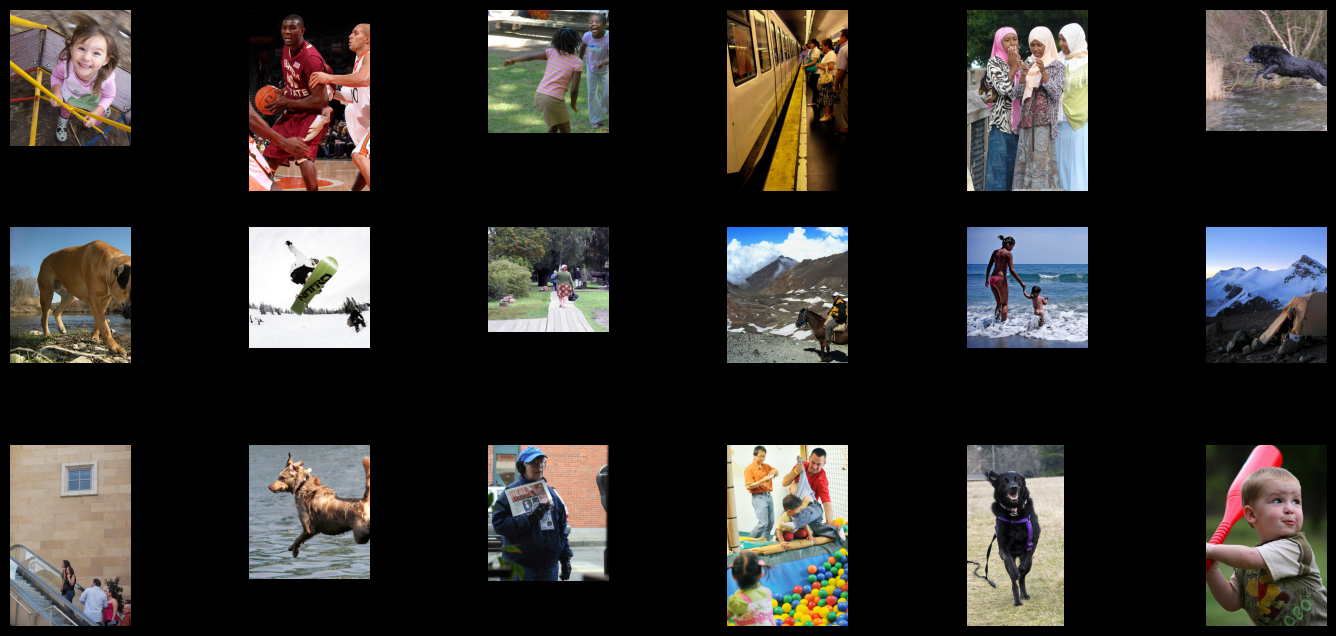

In [ ]:
# cписок изображений для отображения
show_img = train_images[start : stop]
# строим график
fig, ax = plt.subplots(nrows = 3,
                       ncols = 6,
                       figsize = (18, 8),
                       sharey = True,
                       sharex = True)

for i, ax_i in enumerate(ax.flatten()):
  # получаем путь для каждого изображения
  img = Image.open(show_img[i])

  # выводим на экран
  ax_i.imshow(img)
  ax_i.axis('off')

plt.show()

Изображения отображаются ожидаемо:
- они цветные
- имеют разный размер

### Загрузка Датасетов


Для работы нам необходимо выбрать датасет который можно использовать для работы

#### Train dataset

Для того, чтобы избежать ошибок при открытии датасетов используем функцию для поиска разделителя в тексте

In [ ]:
# функция чтобы узнать какой использован разделитель
path = '/kaggle/working/to_upload/train_dataset.csv'

def find_delimiter(path_to_file):
    sniffer = csv.Sniffer()
    with open(path_to_file) as fp:
        delimiter = sniffer.sniff(fp.read(5000)).delimiter
    return delimiter

# посмотрим разделитель
find_delimiter(path)

','

In [ ]:
# загружаем файл csv
path = '/kaggle/working/to_upload/train_dataset.csv'
train_data = pd.read_csv(path,
                         sep = find_delimiter(path))

In [ ]:
# Оценим содержание данных
train_data.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [ ]:
train_data['query_text'][15]

'A girl wearing a yellow shirt and sunglasses smiles .'

query_text Обучающей выборки содержит короткий текст на английском языке, включая символы препинания

In [ ]:
# сгруппируем данные по названию изображений чтобы
#проверить сколько описаний доступно для каждго изображения
describes_count = train_data.groupby(['image'])\
.agg(count = ('query_id', 'count'))

describes_count.head()

,count
image,
1056338697_4f7d7ce270.jpg,8
106490881_5a2dd9b7bd.jpg,8
1082379191_ec1e53f996.jpg,4
1084040636_97d9633581.jpg,6
1096395242_fc69f0ae5a.jpg,5


В описании к заданию говорится что для каждого изображения при тестировании будет доступно до 5 описаний, но мы видим, что для некоторых объектов в тренировочных данных их больше чем 5.
отобразим это на графике

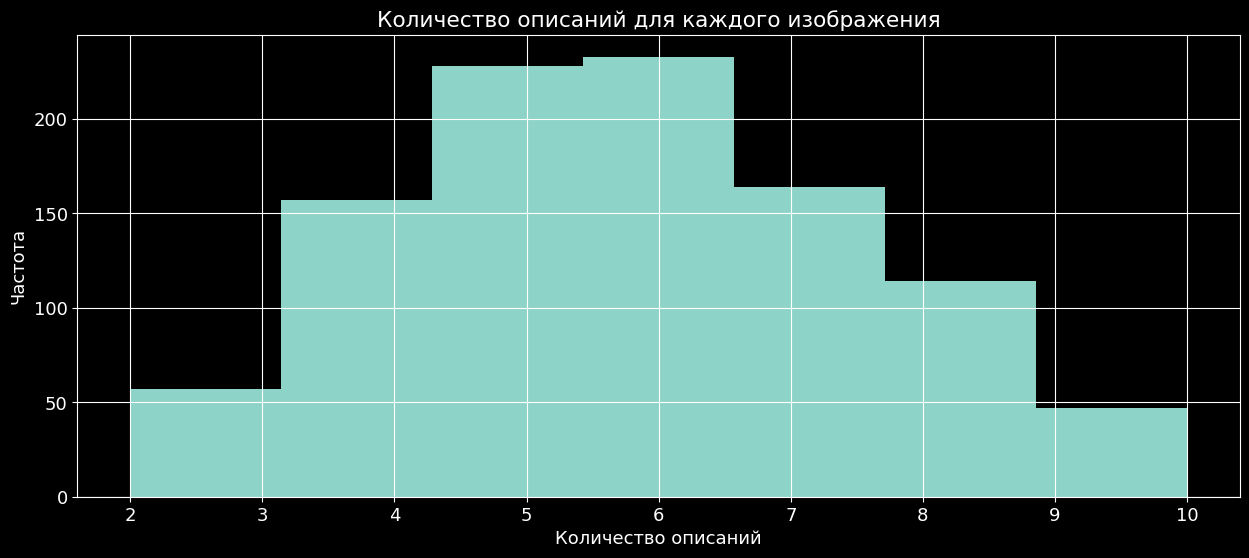

In [ ]:
# количество имеющихся описаний для изображений
describes_count['count'].plot(kind = 'hist',
                              bins = 7,
                              grid = True,
                              figsize = (15, 6))
plt.title('Количество описаний для каждого изображения')
plt.xlabel('Количество описаний')
plt.ylabel('Частота')
plt.show()

**Вывод**

Cодержание файла train_dataset.csv соответствует описанному:

В файле train_dataset.csv находится информация, необходимая для обучения:
- image	 имя файла изображения
- query_id	идентификатор описания. Идентификатор описания имеет формат

`<имя файла изображения>#<порядковый номер описания>`
- query_text текст описания.


#### Test dataset

In [ ]:
# загрузим test.csv
test_data = pd.read_csv('/kaggle/working/to_upload/test_images.csv')
test_data.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


Видим, что файл test.csv содержит 100 строк с названиями изображений

#### Test queries

In [ ]:
# посмотрим данные с тестовыми запросами
path = '/kaggle/working/to_upload/test_queries.csv'
test_queries = pd.read_csv(path,
                  sep = find_delimiter(path),
                  engine = 'python')
test_queries.head()

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [ ]:
# посмотрим что содержится в столбце query_text
test_queries['query_text'][0]

'Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .'

query_text содержит текст на английском языке, который имеет знаки препинания.

В файле test_queries.csv находится информация, необходимая для тестирования:
- идентификатор запроса. Идентификатор запроса имеет формат `<имя файла изображения>#<порядковый номер описания>`
- текст запроса
- релевантное изображение.

У нас есть 100 изображений и 500 описаний. В Описании к проекту сообщалось, что для каждого изображения может быть не более 5 описаний, поэтому с данными все нормально.

#### Crowd Annotations

In [ ]:
# проанализируем файл с описаниями
path = '/kaggle/working/to_upload/CrowdAnnotations.tsv'
crowd_annotations = pd.read_csv (path,
                                 sep = find_delimiter(path),
                                 header = None)
crowd_annotations.head()

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [ ]:
# переименуем колонки чтобы они стали более информативные
crowd_annotations.columns = ['image', 'query_id', 'match_conf_rate', 'num_match', 'num_no_match']
crowd_annotations.head()

,image,query_id,match_conf_rate,num_match,num_no_match
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [ ]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   query_id         47830 non-null  object 
 2   match_conf_rate  47830 non-null  float64
 3   num_match        47830 non-null  int64  
 4   num_no_match     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [ ]:
# оценим количество уникальных изображений для которых имеются описания
crowd_annotations.groupby(['image']).agg(image_count = ('image', 'count')).head()

,image_count
image,
1056338697_4f7d7ce270.jpg,50
106490881_5a2dd9b7bd.jpg,50
1082379191_ec1e53f996.jpg,30
1084040636_97d9633581.jpg,50
1096395242_fc69f0ae5a.jpg,50


In [ ]:
crowd_annotations['query_id'][1]

'114051287_dd85625a04.jpg#2'

В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга.
Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- Доля людей, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание не соответствует изображению

Всего имеется 47830 описаний для 1000 уникальных изображений

#### Expert Annotations

In [ ]:
# проанализируем файл с экспертными описаниями
path = '/kaggle/working/to_upload/ExpertAnnotations.tsv'

expert_annotations = pd.read_csv (path,
                                  sep = find_delimiter(path),
                                  header = None)
expert_annotations.head()

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [ ]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов.
 Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где:

 1 — изображение и запрос совершенно не соответствуют друг другу,

 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует,

 3 — запрос и текст соответствуют с точностью до некоторых деталей,

 4 — запрос и текст соответствуют полностью.      

In [ ]:
# переименуем колонки чтобы они стали более информативные
expert_annotations.columns = ['image', 'query_id', 'exp1', 'exp2', 'exp3']
expert_annotations.head()

,image,query_id,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


Я вижу, что id изображения и id в описании запроса (query_id) различаются.
Я хочу убедиться, что это не из-за ошибки загрузки.
Это может быть сделано специально для зашумления и проверки.
Если в данных имеются изображения с такими id, то вероятнее всего это было сделано в рамках получения экспертных оценок.

In [ ]:
expert_annotations.loc[expert_annotations['image'] == '3181701312_70a379ab6e.jpg']

,image,query_id,exp1,exp2,exp3
3238,3181701312_70a379ab6e.jpg,132489044_3be606baf7.jpg#2,2,2,2
3239,3181701312_70a379ab6e.jpg,2544182005_3aa1332bf9.jpg#2,1,1,1
3240,3181701312_70a379ab6e.jpg,2985679744_75a7102aab.jpg#2,3,3,3
3241,3181701312_70a379ab6e.jpg,307327914_f98f576adb.jpg#2,1,1,2
3242,3181701312_70a379ab6e.jpg,3437654963_c4fdc17e8b.jpg#2,1,1,1
3243,3181701312_70a379ab6e.jpg,3494394662_3edfd4a34c.jpg#2,1,1,2


Видим, что для этого изображения экспертам были предложены некоторые описания других файлов и по некоторым из описаний эксперты подтвердили наличие частичного сходства

**ВЫВОД:**

Все данные загружены
1. имеется 5 таблиц и 1100 изображений
2. Табличные данные различаются по размеру и содержанию.
3. Изображения цветные, разного размера
4. Изображений без описаний и без оценки нет
5. Таблицы содержат строковый тип данный и int.
6. В качестве объекта  будут использованы пары изображение - описание.
7. В качестве метки класса - оценка эксперта (от 1 до 4) привиденные к интервалу 0-1


#### Объединение данных в датасет

Нам необходимо выбрать способ объединения и призаки по которым мы будем объединять датасеты.

Нужно оценить полноту данных и их соответствие по объектам чтобы в результате получить инормативные признаки для объектов


**Crowd_annotations and train**

Проверим совпадают ли уникальные изображения и запросы в обоих датасетах

In [ ]:
a1 = np.array(sorted(train_data['image'].unique()))
a1.shape

(1000,)

In [ ]:
a2 = np.array(sorted(crowd_annotations['image'].unique()))
a2.shape

(1000,)

In [ ]:
np.array_equal(a1, a2)

True

Изображения идентичные

In [ ]:
a1 = np.array(sorted(train_data['query_id'].unique()))
a1.shape

(977,)

In [ ]:
a2 = np.array(sorted(crowd_annotations['query_id'].unique()))
a2.shape

(1000,)

Количество query_id в обоих выборках отличается, в тренировочной выборке на 23 ункальных описания меньше чем в crowd_annotations.

**Expert annotation and train**

Теперь проверим по expert annotation

In [ ]:
expert_annotations.head()

,image,query_id,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [ ]:
a1 = np.array(sorted(train_data['image'].unique()))
a1.shape

(1000,)

In [ ]:
a2 = np.array(sorted(expert_annotations['image'].unique()))
a2.shape

(1000,)

In [ ]:
np.array_equal(a1,a2)

True

Видим что id фотографии в обучающем датасете и фотографии в описательном датасете абсолютно идентичны.

In [ ]:
# проверим колонку query_id п
a1 = np.array(sorted(train_data['query_id'].unique()))
a2 = np.array(sorted(expert_annotations['query_id'].unique()))
print (a1.shape, a2.shape)

(977,) (977,)


In [ ]:
# Проверим по идентификаторам
np.array_equal(a1,a2)

True

Оценим итоговый датафрейм при попарном объединении датасетов:
- объединим датасеты по колонкам image, query_id по типу inner,  чтобы в итоговый датасет вошли данные имеющиеся в обоих датасетах.
-  Финальный датасет будет включать все колонки обхединенных датасетов

In [ ]:
# предварительно оцениваем итоговый датафрейм
#crowd_annotations

train_data.merge(crowd_annotations,
                 on = ['image', 'query_id'],
                 how = 'inner')

,image,query_id,query_text,match_conf_rate,num_match,num_no_match
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0,3
1,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0,3
2,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,3,0
3,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0,3
4,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0,3
...,...,...,...,...,...,...
2324,476759700_8911f087f8.jpg,1082379191_ec1e53f996.jpg#2,A man and a woman sitting on a dock .,0.000000,0,3
2325,561417861_8e25d0c0e8.jpg,410453140_5401bf659a.jpg#2,A man stands at the entrance of Yerba Buena Ce...,0.000000,0,3
2326,561940436_64d6fc125d.jpg,3157847991_463e006a28.jpg#2,Two men in black jackets behind a white handra...,0.000000,0,3
2327,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,0.333333,1,2


Видим что очень много данных мы потеряли, более половины.

In [ ]:
# оценим объединение с экспертными оценками
train_data.merge(expert_annotations,
                 on = ['image', 'query_id'],
                 how = 'inner')

,image,query_id,query_text,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,4,4,4
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1
...,...,...,...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,2,2,3
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,1,1,1
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,2,2,2
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,2,3,3


Видим, что экспертные оценки имеются для обоих датасетов.

Для работы я создам датасет из train_data и expert_data по жлементам содержащимся в обоих датасетах.

Я пренебрегу данными содеращимися в crowd_annotaitios, и не буду объединять по типу outer. Если в результате анализа и машинного обучения удастся достичь адекватой метрики

In [ ]:
# объединяем
experts = train_data.merge(expert_annotations,
                           on = ['image', 'query_id'],
                           how = 'inner')
experts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
 3   exp1        5822 non-null   int64 
 4   exp2        5822 non-null   int64 
 5   exp3        5822 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 273.0+ KB


- Пропусков нет
- Тип данных не изменился
- Все строки и колонки на месте.

слияние произведено успешно

**Вывод**
- Все данные имещиеся исходном датасете к пеоекту были загружены
- Исзодный датасет содержал 5 таблиц формата csv, 2 папки с изображениями 1000 и 100 штук

Нам предстоит работать с данными, которые имеют размер  5822 строк и 6 колонок:
- query_id  / тип данных object
- query_text / тип данных   object
- exp1 / тип данных   int64
- exp2  /  тип данных int64
- exp 3 / тип данных int64

## Предварительный анализ и предобработка

Проведем анализ и оценим данные на наличие пропусков, выбросов, отсутствия необходимых значений.

#### Анализ экспертных оценок

Проанализируем значения, содержащиеся в признаке 'exp1','exp2', 'exp3' чтобы убедиться в отсутствии оценок выходящих за заявленных диапазон значений.


In [ ]:
# проверим все ли оценки входят в заданный диапазон (1-4)
pd.concat([experts[['exp1','exp2', 'exp3']].min(), experts[['exp1','exp2', 'exp3']].max()], axis =1)

,0,1
exp1,1,4
exp2,1,4
exp3,1,4


Объекты с оценками, выходящими за диапазон допустимых значений отсутствуют, все оценки находятся в диапазоне 0-4

In [ ]:
# усредним оценки экспертов
avg = experts[['exp1','exp2', 'exp3']].mean(axis = 1)
avg

0       1.000000
1       1.000000
2       1.666667
3       4.000000
4       1.000000
          ...   
5817    2.333333
5818    1.000000
5819    2.000000
5820    2.666667
5821    1.000000
Length: 5822, dtype: float64

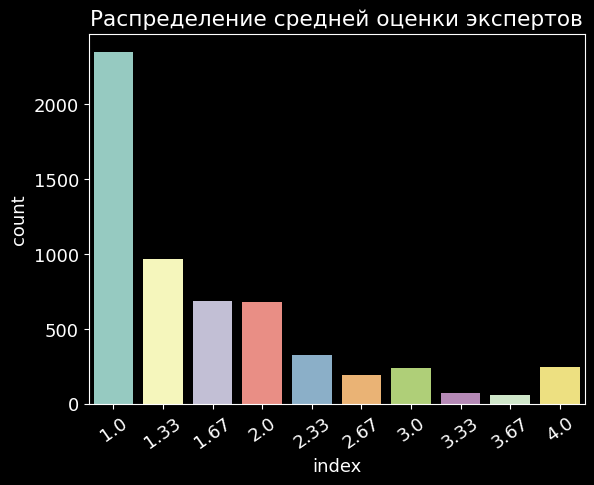

In [ ]:
# отразим усредненные оценки на диаграмме
to_plot = avg.value_counts().reset_index()
indexes = to_plot['index'].round(2)
sns.barplot(to_plot,
            x = indexes,
            y = to_plot['count']
            )
plt.title('Распределение средней оценки экспертов')
plt.xticks(rotation = 35)
plt.show()

- Большинство объектов имеют единогласное среднее значение 1, что соответствует негативному классу (описание и изображение не соответствуют)
- положительного класса (единогласные 4) у нас крайне мало, что говорит о дисбалансе классов.


Видим что у нас нет объектов с отсутствующей оценкой

In [ ]:
# приводим к виду 0/1
experts[['exp1', 'exp2','exp3']] = experts[['exp1', 'exp2','exp3']].apply(lambda x: (x-1)/3)
experts[['exp1', 'exp2','exp3']].head()


,exp1,exp2,exp3
0,0.0,0.000000,0.000000
1,0.0,0.000000,0.000000
2,0.0,0.333333,0.333333
3,1.0,1.000000,1.000000
4,0.0,0.000000,0.000000


In [ ]:
# добавим среднее значение оценок
experts['avg'] = experts[['exp1', 'exp2','exp3']].mean(axis = 1)
experts.head()

,image,query_id,query_text,exp1,exp2,exp3,avg
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,0.000000,0.000000,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,0.000000,0.000000,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,0.333333,0.333333,0.222222
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.0,1.000000,1.000000,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,0.000000,0.000000,0.000000


### Поиск и удаление запрещенного контента

создадим функцию которая выведет индексы пары элементов у которых в запросе имеются слова из списка blacklist

In [ ]:
def censorship(queries_series, stop_words_list):
    indexes = []
    for i in range(len(queries_series)):
        for item in stop_words_list:
            if item in queries_series[i]:
                indexes.append(i)
    return indexes

In [ ]:
# создадим список запрещенных слов
blacklist = ["child",
             "kid",
             "minor",
             "underage",
             "juvenile",
             "baby",
             "toddler",
             "preschooler",
             "teen",
             "youth",
             "young",
             "boy",
             "girl",
             "infant",
             "adolescent",
             "schoolchild",
             "underage",
             "teenagers",
             "youn",
             "different ages",
             "parents",
             "families",
             "infants",
             "childcare",
            "adolescent",
            "preschool",
             "school",
            "teenage",
             "infants",
            "family",
            "children's",
            "child",
            "children"
                                ]

In [ ]:
# сохраним индексы длоя удаления в переменную
objects_to_del = censorship(experts['query_text'], blacklist)

# оценим длину запрещенных объектов
len(objects_to_del)

2835

In [ ]:
# удаляем
experts.drop(index = objects_to_del, inplace = True)

In [ ]:
# проверяем
experts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4228 entries, 22 to 5821
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4228 non-null   object 
 1   query_id    4228 non-null   object 
 2   query_text  4228 non-null   object 
 3   exp1        4228 non-null   float64
 4   exp2        4228 non-null   float64
 5   exp3        4228 non-null   float64
 6   avg         4228 non-null   float64
dtypes: float64(4), object(3)
memory usage: 264.2+ KB


- Видим, что удалены все объекты, содержащие запрещенные слова из списка blacklist
- пропусков не появилось

**Вывод**

Имеем датасет включающий в себя только объекты тренировочной выборки с экспертными оценками и удаленными запрещенными словами, относящимися к несовершеннолетним людям, которые сохранены в переменной blacklist

## Подготовка текста для машинного обучения


## Эмбединги

Векторизацию текста будем производить библиотекой BERT


#### Векторизация текста

In [ ]:
# сохраним текст для обработки в переменную
corpus = experts['query_text'].copy()

In [ ]:
# Загрузка предварительно обученной модели BERT и токенизатора
model_name = 'bert-base-uncased'  # Имя модели можно заменить на другие варианты
# Загрузка токенизатора
tokenizer = BertTokenizer.from_pretrained(model_name,  do_lower_case = True)
model = BertModel.from_pretrained(model_name).to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_embeddings(text):
    token = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        output = model(**token)
        embeddings = output.last_hidden_state
    return embeddings.mean(dim = 1).squeeze().cpu().numpy()

In [ ]:
text_embeddings = corpus.progress_apply(get_embeddings)
text_embeddings.shape

  0%|          | 0/4228 [00:00<?, ?it/s]

(4228,)

In [ ]:
text_embeddings.head()

22    [0.49547416, -0.22037096, 0.15132737, 0.021880...
23    [0.49547416, -0.22037096, 0.15132737, 0.021880...
24    [0.49547416, -0.22037096, 0.15132737, 0.021880...
25    [0.49547416, -0.22037096, 0.15132737, 0.021880...
26    [0.49547416, -0.22037096, 0.15132737, 0.021880...
Name: query_text, dtype: object

In [ ]:
# оценим длину одного элемента
len(text_embeddings[22])

768

In [ ]:
# добавляем в итоговый дф
experts['text_emb'] = text_embeddings

# проверяем результат
experts.head()

,image,query_id,query_text,exp1,exp2,exp3,avg,text_emb
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.000000,0.000000,0.333333,0.111111,"[0.49547416, -0.22037096, 0.15132737, 0.021880..."
23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.000000,0.333333,0.333333,0.222222,"[0.49547416, -0.22037096, 0.15132737, 0.021880..."
24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.333333,0.333333,0.333333,0.333333,"[0.49547416, -0.22037096, 0.15132737, 0.021880..."
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.000000,0.333333,0.333333,0.222222,"[0.49547416, -0.22037096, 0.15132737, 0.021880..."
26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.000000,0.000000,0.333333,0.111111,"[0.49547416, -0.22037096, 0.15132737, 0.021880..."


**Вывод**

- Эмбеддинги текстовых описаний получены

#### Векторизация изображений


Векторизацию изображений будем осуществлять с помощью предобученной модлеи Resnet50

In [ ]:
# Загрузка предварительно обученной модели ResNet
model = resnet50(pretrained = True)

# заморозка весов чтобы градиенты не считались
for param in model.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s] 


In [ ]:
# пересоберем нашу модельку
modules = list(model.children())[:-1]
resnet = nn.Sequential(*modules).to(DEVICE)
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
# трансформируем изображения с помощью transformers

norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm
])

In [ ]:
# выберем случайное фото из тренировочного датасета
random_img = experts['image'][np.random.choice(experts.index.to_list())]
random_img

'2542662402_d781dd7f7c.jpg'

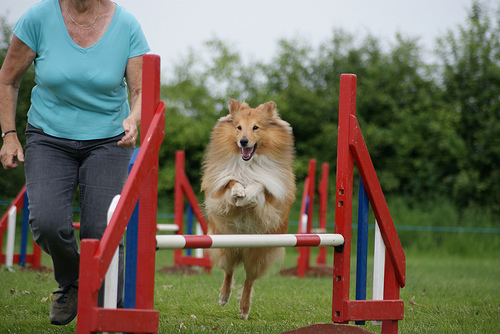

In [ ]:
# откроем
Image.open([img for img in train_images if img.name == random_img][0])\
.convert('RGB')

In [ ]:
# сохраним изображение и его тензор (переведенный в np.array()) в словарь
image_arrays = {'image' : [], 'img_emb' : []}

# токенизирум все изображения тренировочной выборки
for img_path in tqdm(train_images):
    img = Image.open(img_path).convert('RGB')
    image_tensor = preprocess(img).unsqueeze_(0).to(DEVICE) # 3d --> 4
    output_tensor = resnet(image_tensor).flatten()

    #добавляем тензор в словарь
    image_arrays['img_emb'].append(output_tensor.detach().cpu().numpy().flatten())
    image_arrays['image'].append(img_path.name)

  0%|          | 0/1000 [00:00<?, ?it/s]

Для того, чтобы обучить обучить модель нам нужно:
- Перевести изображения в векторы/тензоры
- Перевести описания в векторы/тензоры.

Для того, чтобы передать изображения в нейронную сеть мы напишем класс загрузчика, который будет выполнять следующие функции:
- переводить изображения в тензор
- аугментировать обучающие изображения



In [ ]:
# проверим сколько у нас объектов
print(f'''
Всего объектов: {len(train_images)}
Загружено объектов numpy: {len(image_arrays['image'])} ''')



Всего объектов: 1000
Загружено объектов numpy: 1000 


In [ ]:
torch.cuda.empty_cache()

In [ ]:
image_emb_df = pd.DataFrame(image_arrays)
image_emb_df.head()

,image,img_emb
0,3572267708_9d8a81d4a4.jpg,"[0.0853352, 0.21971048, 0.32608122, 0.11515732..."
1,3053743109_a2d780c0d2.jpg,"[0.09872992, 0.4674346, 0.49324876, 0.3313211,..."
2,491405109_798222cfd0.jpg,"[0.062277675, 1.6541022, 0.57876617, 0.1299212..."
3,3542484764_77d8920ec9.jpg,"[0.55959296, 0.5619242, 2.3890135, 0.34813055,..."
4,2140182410_8e2a06fbda.jpg,"[0.07642282, 0.5038793, 0.38139805, 0.42354578..."


In [ ]:
# объединим итоговый датафрейм df с датафреймом
#из названия изображения и вектора
df = experts.merge(image_emb_df,
                   on = 'image',
                   how = 'inner')
#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4228 entries, 0 to 4227
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4228 non-null   object 
 1   query_id    4228 non-null   object 
 2   query_text  4228 non-null   object 
 3   exp1        4228 non-null   float64
 4   exp2        4228 non-null   float64
 5   exp3        4228 non-null   float64
 6   avg         4228 non-null   float64
 7   text_emb    4228 non-null   object 
 8   img_emb     4228 non-null   object 
dtypes: float64(4), object(5)
memory usage: 297.4+ KB


In [ ]:
# оценим итоговый датафрейм
df.head()


,image,query_id,query_text,exp1,exp2,exp3,avg,text_emb,img_emb
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,0.000000,0.333333,0.111111,"[0.49547416, -0.22037096, 0.15132737, 0.021880...","[0.023042751, 0.92084646, 0.038650297, 0.85825..."
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,0.0,0.333333,0.333333,0.222222,"[0.58239603, -0.3755342, 0.024270808, -0.02205...","[0.023042751, 0.92084646, 0.038650297, 0.85825..."
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,0.0,0.000000,0.333333,0.111111,"[-0.31399477, -0.31099638, 0.053888943, -0.184...","[0.023042751, 0.92084646, 0.038650297, 0.85825..."
3,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,A soccer ball is above the head of a man weari...,0.0,0.000000,0.000000,0.000000,"[0.28717318, -0.020055333, -0.21409161, -0.190...","[0.023042751, 0.92084646, 0.038650297, 0.85825..."
4,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,0.0,0.000000,0.333333,0.111111,"[0.54734623, 0.09250461, 0.21370636, 0.0553391...","[0.023042751, 0.92084646, 0.038650297, 0.85825..."


In [ ]:
# развернем эмбеддинги текста в колонки датафрейма
query_text_df = pd.DataFrame(
    columns = np.arange(0, len(df['text_emb'][0])),
    data = df['text_emb'].to_list())
query_text_df.set_index
query_text_df
query_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4228 entries, 0 to 4227
Columns: 768 entries, 0 to 767
dtypes: float32(768)
memory usage: 12.4 MB


Получилось что теперь наш датасет включает в себя 768 признака

In [ ]:
# присвоим индексы из датасета df
query_text_df.set_index(df.index, inplace = True)

query_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4228 entries, 0 to 4227
Columns: 768 entries, 0 to 767
dtypes: float32(768)
memory usage: 12.4 MB


In [ ]:
query_text_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.495474,-0.220371,0.151327,0.021881,0.227643,0.036067,-0.071937,0.897265,-0.020502,-0.440497,...,0.199519,-0.168477,-0.130826,0.050839,0.137441,0.234322,0.040068,-0.390364,0.070866,0.154538
1,0.582396,-0.375534,0.024271,-0.022054,0.106668,-0.040799,-0.343041,0.530424,-0.515762,-0.104871,...,-0.083037,0.299615,-0.275095,0.257130,0.171890,0.109804,0.300466,-0.337860,-0.231128,0.203774
2,-0.313995,-0.310996,0.053889,-0.184099,0.538726,0.012341,0.062950,1.024061,-0.336021,-0.242609,...,0.215019,-0.496596,0.196086,0.023435,0.058630,-0.225642,-0.428861,-0.376989,0.101353,-0.115983
3,0.287173,-0.020055,-0.214092,-0.190359,0.425609,-0.099590,-0.322149,0.533928,-0.131871,-0.345310,...,-0.414029,-0.054176,-0.092430,0.010714,0.187049,0.057156,-0.019266,0.152453,0.159650,0.040819
4,0.547346,0.092505,0.213706,0.055339,0.404350,-0.124852,-0.001320,0.508875,0.078441,-0.440228,...,-0.063104,-0.258256,-0.196547,0.046042,-0.201219,0.353375,0.062098,-0.510358,0.055820,-0.231715


In [ ]:
# развернем эмбеддинг изображения в колонки датафрейма
image_df = pd.DataFrame(
    columns = np.arange(0, len(df['img_emb'][0])),
    data = df['img_emb'].to_list())
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4228 entries, 0 to 4227
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 33.0 MB


In [ ]:
image_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704
1,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704
2,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704
3,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704
4,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704


In [ ]:
image_df.set_index(df.index, inplace = True)
image_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704
1,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704
2,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704
3,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704
4,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.037381,0.703045,0.55671,0.375198,1.122931,0.27615,1.187245,0.136031,0.175029,0.255704


In [ ]:
df['avg'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4228 entries, 0 to 4227
Series name: avg
Non-Null Count  Dtype  
--------------  -----  
4228 non-null   float64
dtypes: float64(1)
memory usage: 33.2 KB


In [ ]:
df['avg'].head()

0    0.111111
1    0.222222
2    0.111111
3    0.000000
4    0.111111
Name: avg, dtype: float64

In [ ]:
# объединим датафреймы для получения пары признаков изображение/описание
train_data = pd.concat([image_df, query_text_df, df[['image', 'avg']]], axis = 1)
train_data.shape

(4228, 2818)

In [ ]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,image,avg
0,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,-0.130826,0.050839,0.137441,0.234322,0.040068,-0.390364,0.070866,0.154538,1056338697_4f7d7ce270.jpg,0.111111
1,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,-0.275095,0.257130,0.171890,0.109804,0.300466,-0.337860,-0.231128,0.203774,1056338697_4f7d7ce270.jpg,0.222222
2,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,0.196086,0.023435,0.058630,-0.225642,-0.428861,-0.376989,0.101353,-0.115983,1056338697_4f7d7ce270.jpg,0.111111
3,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,-0.092430,0.010714,0.187049,0.057156,-0.019266,0.152453,0.159650,0.040819,1056338697_4f7d7ce270.jpg,0.000000
4,0.023043,0.920846,0.03865,0.858256,0.406687,0.185093,0.730176,1.568475,0.034432,0.0213,...,-0.196547,0.046042,-0.201219,0.353375,0.062098,-0.510358,0.055820,-0.231715,1056338697_4f7d7ce270.jpg,0.111111


Объединение произошло верно:
- Итоговый датафрейм содержит 4228 объектов
- 2818 признаков
- 2048 это развернутый эмбеддинг изображений
- 768 признака развернутого эмбеддинга описания
- целевой признак avg
- 'image' для группировки

In [ ]:
# проверим пропуски
train_data.isna().sum().mean()

0.0

## Машинное обучение

In [ ]:
# сохраним результаты моделей
result = {'model':[], 'metric':[], 'val_metric':[]}

### Деление выборки

Для того чтобы иметь доступ к изображениям после обучения разделим по индексам

In [ ]:
# делим выборку
train_idx, val_idx = train_test_split(train_data.index,
                                      test_size = 0.2,
                                      shuffle = True,
                                      random_state = SEED)
print (f'''
    train выборка {train_idx.shape}

    valid выборка {val_idx.shape}
       ''')


    train выборка (3382,)

    valid выборка (846,)
       


In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.dummy import DummyRegressor

In [ ]:
split = GroupShuffleSplit(n_splits = 1,
                        train_size = .7,
                        random_state = SEED)



In [ ]:
# выделим обучающие и целевой признак
features = train_data.drop(['avg', 'image'], axis = 1)
target = train_data['avg']

In [ ]:
train_idx, val_idx  = next(split.split( X = features,
                                       y = target,
                                        groups = train_data['image']))
# сограним датасеты по индексам
train, valid = train_data.loc[train_idx], train_data.loc[val_idx]

In [ ]:
# выделим обучающие и целевой признак для каждой выборки
train_features = train.drop(['avg', 'image'], axis = 1)
train_target = train['avg']

valid_features = valid.drop(['avg', 'image'], axis =1)
valid_target = valid['avg']

print (f'''
    train выборка {train_features.shape}

    valid выборка {valid_features.shape}
       ''')


    train выборка (2937, 2816)

    valid выборка (1291, 2816)
       


Выборка поделена верно

### Масштабирование
Масштабируем признаки при помощи StandardScaler

In [ ]:
# инициируем
scaler = StandardScaler()

#обучаем и трансформируем обучающую выборку
train_features = scaler.fit_transform(train_features)

# Трансформируем валидационную
val_features = scaler.transform(valid_features)

В качестве метрики  LOSS и для оценки модели будем использовать rmse, так как это стандартная метрика для задач регрессии

### DummyRregressor

In [ ]:
dummy = DummyRegressor( strategy = "mean")
dummy.fit(train_features, train_target)

preds = dummy.predict(train_features)

dummy_rmse = mean_squared_error(train_target, preds, squared = False)

print('RMSE DummyRegressor ', dummy_rmse )

RMSE DummyRegressor  0.27762331675480834


In [ ]:
# добавим результат в переменную
result['model'].append('DummyRegressor')
result['metric'].append(dummy_rmse)
result['val_metric'].append(' - ')

result

{'model': ['DummyRegressor'],
 'metric': [0.27762331675480834],
 'val_metric': [' - ']}

### KNeighborsRegressor

В качестве линейной модели буду использовать модель KNearestNeighbors библиотеки sklearn.

Для получения несмещенной оценки baseline я использую cross_val_score, а затем подберу гиперпараметры с помощью gridsearch

In [ ]:
# инициируем модель
n_neighbors = 25 # установим число соседдей

knn_model = neighbors.KNeighborsRegressor(n_neighbors,
                                          weights = 'distance') # чем дальше тем меньше вес

In [ ]:
# Получим метрику rmse с помощью кроссвалидации
scores = cross_val_score(knn_model,
                         train_features,
                         train_target,
                         cv = 5,
                         scoring  = 'neg_mean_squared_error' )
knn_cvs = np.sqrt(-scores.mean())

print (f'''Cреднее значение RMSE модели knn: {knn_cvs:0.4f}''')

Cреднее значение RMSE модели knn: 0.2444


Видим, что knearest neibhors показала отличный результат - 0.2444

In [ ]:
# добавим результат в переменную
result['model'].append('KNeighborsRegressor(n_neighbors = 25, weights = \'distance\')')
result['metric'].append(knn_cvs)
result['val_metric'].append(' - ')

result

{'model': ['DummyRegressor',
  "KNeighborsRegressor(n_neighbors = 25, weights = 'distance')"],
 'metric': [0.27762331675480834, 0.24439725589001463],
 'val_metric': [' - ', ' - ']}

In [ ]:
# Подберем гиперпараметры
params = {'n_neighbors' : [20, 25, 30, 35, 45],
          'algorithm' : ['auto',  'ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(estimator = knn_model,
                    param_grid = params,
                    cv = 5,
                    scoring = 'neg_mean_squared_error')
grid

GridSearchCV(cv=5,
             estimator=KNeighborsRegressor(n_neighbors=25, weights='distance'),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [20, 25, 30, 35, 45]},
             scoring='neg_mean_squared_error')

In [ ]:
# обучим (это занимает около )
grid.fit(train_features, train_target)
grid_knn_rmse = np.sqrt(-grid.best_score_)
grid.best_estimator_

KNeighborsRegressor(n_neighbors=20, weights='distance')

In [ ]:
print (f'''Лучшее значение RMSE модели knn {grid_knn_rmse}''')

Лучшее значение RMSE модели knn 0.2441210111312042


In [ ]:
# добавим результат в переменную
result['model'].append('KNeighborsRegressor(n_neighbors = 0, weights = \'distance\')')
result['metric'].append(grid_knn_rmse)

result

{'model': ['DummyRegressor',
  "KNeighborsRegressor(n_neighbors = 25, weights = 'distance')",
  "KNeighborsRegressor(n_neighbors = 0, weights = 'distance')"],
 'metric': [0.27762331675480834, 0.24439725589001463, 0.2441210111312042],
 'val_metric': [' - ', ' - ']}

In [ ]:
# выбираем из 2 knn с максимальным скором
if grid_knn_rmse < knn_cvs:
    print(f'''
    Лучшая модель это:
    {grid.best_estimator_}''')
else: print (f'''Лучшая модель это:
    {knn_model}''')


    Лучшая модель это:
    KNeighborsRegressor(n_neighbors=20, weights='distance')


In [ ]:
knn_preds = grid.best_estimator_.predict(val_features)

In [ ]:
# Оценим knn на валидации
val_knn_rmse = mean_squared_error(valid_target, knn_preds, squared = False)
print (f'''  RMSE модели knn {val_knn_rmse} ''')

  RMSE модели knn 0.24311589223767896 


In [ ]:
# добавим результат в переменную

result['val_metric'].append(val_knn_rmse)
result

{'model': ['DummyRegressor',
  "KNeighborsRegressor(n_neighbors = 25, weights = 'distance')",
  "KNeighborsRegressor(n_neighbors = 0, weights = 'distance')"],
 'metric': [0.27762331675480834, 0.24439725589001463, 0.2441210111312042],
 'val_metric': [' - ', ' - ', 0.24311589223767896]}

In [ ]:
# выведем первые пять объектов с максимальным предсказанием
pd.DataFrame(knn_preds).sort_values(ascending = False, by = 0).head()

,0
823,0.887139
822,0.869363
819,0.867324
277,0.785443
894,0.775522


In [ ]:
# сохраним индексы в переменную
knn_max_preds_idx = pd.DataFrame(knn_preds).sort_values(ascending = False, by = 0).head().index

**Отобразим на графике изображения**

In [ ]:
# сохраняем названия изображений
knn_preds_img_names = df['image'].iloc[knn_max_preds_idx].to_list()

In [ ]:
# выведем эти объекты
show_img = []

for img_name in knn_preds_img_names:
    for img_path in train_images:
        if img_path.name == img_name:
             show_img.append(img_path)
print (len(show_img))

5


In [ ]:
# text queries для этих объектов
ax_title = df.iloc[knn_max_preds_idx]['query_text'].to_list()
ax_title

['Two men and a woman smile at the camera .',
 'A brown dog with a tennis ball its mouth rolling on its back on a grassy surface .',
 'A surfer in water and foam .',
 'A Sheltie dog carries a white-colored toy in its mouth as it walks across the snow .',
 'A white dog runs in the grass ,']

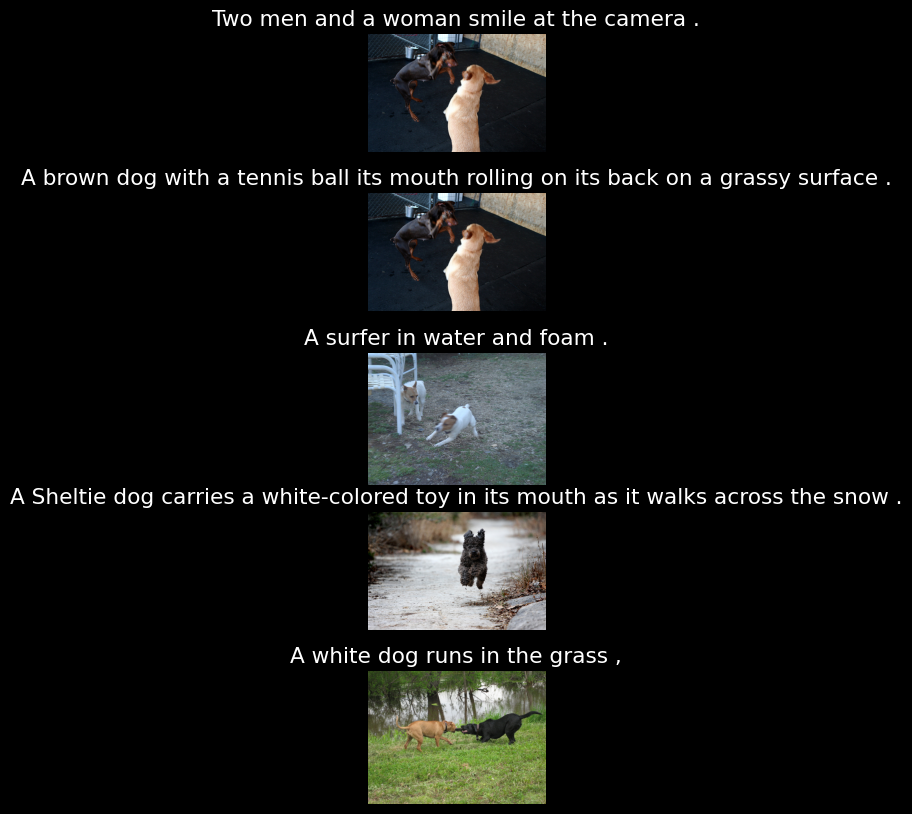

In [ ]:
# строим график
fig, ax = plt.subplots(nrows = 5,
                       ncols = 1,
                       figsize = (10,10),
                       sharey = True,
                       sharex = True)

plt.subplots_adjust(hspace = .2,  wspace = 0.4)

for i, ax_i in enumerate(ax.flatten()):
    # получаем путь для каждого изображения
    img = Image.open(show_img[i])

    # выводим на экран
    ax_i.imshow(img)
    ax_i.axis('off')
    ax_i.set_title(ax_title[i])

plt.show()

Очень любопытные результаты))

|Модель|Метрика|
|-|-|
|DummyRegressor|0.278|
|KNN cross_val_score | 0.2443|
|KNN grid_search|0.2441|

Линейная модель дала результат rmse метрики близкий к dummyregr

### Нейронная сеть

В задании к преокту сказано использовать нейронную сеть с полносвязными слоями, поэтому начнем с простой архитектуры: последовательные полносвязные слои.
после анализа обучения и метрики сделаем вывод о необходимости улучшения сети

In [ ]:
# создадим нейронную сеть
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, dropout_rate=0.5):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.layer4 = nn.Linear(hidden_size3, hidden_size4)
        self.dropout4 = nn.Dropout(p=dropout_rate)
        self.layer5 = nn.Linear(hidden_size4, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout3(x)
        x = torch.relu(self.layer4(x))
        x = self.dropout4(x)
        x = torch.sigmoid(self.layer5(x))

        return x


In [ ]:
# функция обучения
def train(model, optimizer, epochs, X_train, y_train, X_val, y_val, criterion):

    history = {'train': [], 'valid': []}

    # обучение
    for epoch in range(epochs):

        # Forward
        outputs = model(train_features)

        # loss
        loss = criterion(train_target.view(-1, 1), outputs)

        # Backward и optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # выводим loss
        if (epoch == 0) or  (epoch % 10 == 0):
            print(f'Epoch {epoch}/{epochs}, Train Loss: {loss.item()}')

            # оцениваем эпоху
            model.eval()
            with torch.no_grad():
                val_outputs = model(val_features)
                val_loss = criterion(valid_target, val_outputs)
                val_metric = mean_squared_error(valid_target, val_outputs, squared=False)
                history['valid'].append(val_loss.detach().numpy())
                history['train'].append(loss.detach().numpy())
                print(f'Validation Loss: {val_loss.item()}')

    return model, history

In [ ]:
# переводим имеющийся датасет в тензоры
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(np.array(train_target), dtype = torch.float32)

# Проверка размерностей
print("Train features shape:", train_features.shape)
print("Train target shape:", train_target.shape)
print()

val_features = torch.tensor(val_features, dtype = torch.float32)
valid_target = torch.tensor(np.array(valid_target), dtype = torch.float32)

# Проверка размерностей
print("Validation features shape:", val_features.shape)
print("Validation target shape:", valid_target.shape)

Train features shape: torch.Size([2937, 2816])
Train target shape: torch.Size([2937])

Validation features shape: torch.Size([1291, 2816])
Validation target shape: torch.Size([1291])


In [ ]:
# параметры слоев
input_size = train_features.shape[1]
hidden_size1 = int (input_size  * 0.7)
hidden_size2 = int (hidden_size1 * 0.5)
hidden_size3 = int (hidden_size2 * 0.5)
hidden_size4 = int (hidden_size3 * 0.5)
output_size = 1

#  инициируем модель
nn_model = RegressionModel(input_size,
                           hidden_size1,
                           hidden_size2,
                           hidden_size3,
                           hidden_size4,
                           output_size)
print (nn_model)

RegressionModel(
  (layer1): Linear(in_features=2816, out_features=1971, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=1971, out_features=985, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=985, out_features=492, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (layer4): Linear(in_features=492, out_features=246, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (layer5): Linear(in_features=246, out_features=1, bias=True)
)


In [ ]:
# задаем параметры
criterion = nn.MSELoss()  # MSE Loss
optimizer = optim.Adam(nn_model.parameters(), lr = 0.001)

# количество эпох
epochs = 60

# параметры для передачи модели
params = {'model' : nn_model,
          'optimizer' : optimizer ,
          'epochs' : epochs,
          'X_train' : train_features,
          'y_train' : train_target,
          'X_val' : val_features,
          'y_val' : valid_target,
          'criterion' : criterion}

In [ ]:
# обучаем модель
trained_model, training_history = train(**params)

Epoch 0/60, Train Loss: 0.14245153963565826
Validation Loss: 0.08224740624427795
Epoch 10/60, Train Loss: 0.046469565480947495
Validation Loss: 0.09923918545246124
Epoch 20/60, Train Loss: 0.03069906309247017
Validation Loss: 0.10948490351438522
Epoch 30/60, Train Loss: 0.022023284807801247
Validation Loss: 0.1116410419344902
Epoch 40/60, Train Loss: 0.01604774408042431
Validation Loss: 0.11979223042726517
Epoch 50/60, Train Loss: 0.010891688987612724
Validation Loss: 0.1273168921470642


In [ ]:
# Получаем предсказания
nn_model.to(DEVICE).eval() # перевела на gpu, больше не будет ошибки
with torch.no_grad():
    val_outputs = nn_model(val_features.to(DEVICE))
    predictions = val_outputs.cpu().numpy().flatten()
nn_rmse = mean_squared_error(valid_target, predictions, squared = False)

print (f'''RMSE полносвязной нейронной сети: {nn_rmse}''')

RMSE полносвязной нейронной сети: 0.2265283316373825


In [ ]:
# добавим результат в переменную
result['model'].append('Полносвязная нейронная сеть')
result['metric'].append(np.array(training_history['train']).mean())
result['val_metric'].append(nn_rmse)

result

{'model': ['DummyRegressor',
  "KNeighborsRegressor(n_neighbors = 25, weights = 'distance')",
  "KNeighborsRegressor(n_neighbors = 0, weights = 'distance')",
  'Полносвязная нейронная сеть'],
 'metric': [0.27762331675480834,
  0.24439725589001463,
  0.2441210111312042,
  0.044763815],
 'val_metric': [' - ', ' - ', 0.24311589223767896, 0.22652833]}

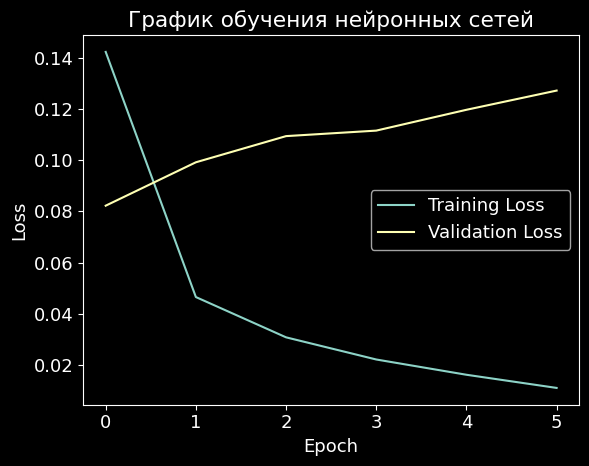

In [ ]:
#  loss на train
plt.plot(training_history['train'], label = 'Training Loss')

#  loss на validation
plt.plot(training_history['valid'], label = 'Validation Loss')

#  labels / legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('График обучения нейронных сетей')
#
plt.show()

- Видим, что модель обучается ПЛОХО, она не сошлась,
- Метрика достигает приемлемых показателей относительно линейной модели

## Сравнение моделей

In [ ]:
pd.DataFrame(result)

,model,metric,val_metric
0,DummyRegressor,0.277623,-
1,"KNeighborsRegressor(n_neighbors = 25, weights ...",0.244397,-
2,"KNeighborsRegressor(n_neighbors = 0, weights =...",0.244121,0.243116
3,Полносвязная нейронная сеть,0.044764,0.226528


Видим что лучший результат показала модель нейронная сеть, хотя и он не сильно хорош)

## Предобработка тестовых данных

In [ ]:
# посмотрим как выглядят наши данные
test_data

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
...,...
95,2431120202_b24fe2333a.jpg
96,2399219552_bbba0a9a59.jpg
97,3091962081_194f2f3bd4.jpg
98,2670637584_d96efb8afa.jpg


In [ ]:
test_queries.head()

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [ ]:
# удалим лишние признаки
test_queries.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


Обработаем текст запроса анологично тому как сделали с обучающей выборкой, но добавим выдачу лемматизированного текстового запроса чтобы при тестировании получать соответствующее изображение

In [ ]:
model = BertModel.from_pretrained(model_name).to(DEVICE)
# сохраним эмбеддинги и обработанный текст в переменные
test_queries ['text_emb'] = test_queries['query_text'].progress_apply(get_embeddings)
test_queries

  0%|          | 0/500 [00:00<?, ?it/s]

,query_id,query_text,image,text_emb
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,"[0.35292754, -0.09760959, -0.5293538, 0.052524..."
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,"[0.46549562, 0.27844453, -0.13862972, -0.05794..."
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,"[0.15756452, 0.40162367, -0.4957069, 0.1231367..."
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,"[0.4709221, 0.33412227, -0.21258394, 0.0429441..."
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,"[0.6395136, 0.33470872, -0.074781395, -0.00364..."
...,...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg,"[0.16217577, 0.100551, -0.47751436, -0.2704379..."
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg,"[0.10478706, 0.05690546, -0.24958189, -0.24357..."
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg,"[0.11721846, 0.30135503, -0.2835659, -0.132079..."
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg,"[0.22586875, 0.31092155, -0.6001655, -0.160854..."


**Эмбеддинг тестовых изображений**

In [ ]:
# сохраним изображение и его вектор (тип np.array() )
test_img_emb = {'image' : [], 'imb_emb' : []}

for img_path in tqdm(test_images):
    img = Image.open(img_path).convert('RGB')
    image_tensor = preprocess(img).unsqueeze_(0).to(DEVICE) # 3d --> 4
    output_tensor = resnet(image_tensor).flatten()

    #добавляем тензор в словарь
    test_img_emb ['imb_emb'].append(output_tensor.detach().cpu().numpy().flatten())
    test_img_emb ['image'].append(img_path.name)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# проверим сколько у нас объектов
print(f'''
Всего объектов: {len(test_images)}

Загружено объектов numpy: {len(test_img_emb['image'])}''')


Всего объектов: 100

Загружено объектов numpy: 100


In [ ]:
test_img_emb.keys()

dict_keys(['image', 'imb_emb'])

In [ ]:
# развернем эмбеддинг изображения в колонки датафрейма
test_img_emb_df = pd.DataFrame(
    columns = np.arange(0, len(test_img_emb['imb_emb'][0])),
    data = test_img_emb['imb_emb']
    )
test_img_emb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 800.1 KB


In [ ]:
# Признаки развернуты правильно
test_img_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.099916,0.635240,0.253708,0.468816,0.191564,0.070274,0.778156,0.073601,0.035198,0.690738,...,0.084896,0.000000,0.127018,0.447057,0.057679,0.264503,0.065115,0.334924,0.520011,0.305486
1,0.099655,0.122191,0.802452,0.163987,0.232683,0.246373,0.636549,0.553199,0.147930,0.456568,...,0.271468,0.495553,0.009916,0.314096,0.251065,0.293429,0.784746,0.058086,0.464105,0.264141
2,0.931158,0.947966,0.613466,0.549747,0.431527,1.107993,1.813177,0.515798,0.435261,0.274138,...,0.036916,0.287312,0.113837,0.583396,2.123746,0.153220,0.225626,0.322320,0.434963,0.168419
3,0.011509,1.399923,1.543455,0.153156,0.343632,0.057356,0.017725,0.630668,0.222698,0.414600,...,0.157220,0.043106,0.507752,0.421309,0.659041,0.236937,0.144993,0.155404,0.956511,0.401603
4,0.057218,0.722591,0.369721,0.350784,0.453491,0.268206,0.943532,0.781865,0.268198,0.366658,...,0.180460,0.244322,0.291779,0.198819,0.793227,0.314102,0.607752,0.190944,0.370290,0.529309


In [ ]:
# развернем эмбеддинг описания в колонки датафрейма
test_query_emb_df = pd.DataFrame(
    columns = np.arange(0, len(test_queries['text_emb'][0])),
    data = test_queries['text_emb'].to_list()
    )
test_query_emb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 768 entries, 0 to 767
dtypes: float32(768)
memory usage: 1.5 MB


In [ ]:
test_query_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.352928,-0.097610,-0.529354,0.052525,0.365833,-0.333446,-0.039904,0.615075,-0.045736,-0.236511,...,-0.661836,-0.039936,-0.203756,-0.071860,-0.404685,0.122852,-0.172526,0.094938,0.185473,-0.086605
1,0.465496,0.278445,-0.138630,-0.057946,0.217958,-0.703346,-0.127743,0.773907,-0.055648,0.018182,...,-0.808918,0.096629,-0.221170,0.063185,-0.228735,0.016813,0.089104,-0.052803,0.032144,-0.090564
2,0.157565,0.401624,-0.495707,0.123137,0.050297,-0.417935,-0.070533,0.297355,-0.140456,-0.177448,...,-0.191140,-0.071672,-0.132974,0.185770,0.147537,-0.233525,-0.070953,-0.162383,0.094949,-0.224954
3,0.470922,0.334122,-0.212584,0.042944,0.336740,-0.354172,-0.341812,0.554658,0.167196,-0.286570,...,-0.696940,-0.024226,-0.398839,0.141729,-0.198868,-0.156440,0.012914,-0.227518,0.129956,-0.001356
4,0.639514,0.334709,-0.074781,-0.003645,0.165248,-0.525348,-0.138677,0.498119,0.153525,-0.118587,...,-0.622084,0.062558,-0.429334,0.113387,-0.240647,0.052948,0.111829,-0.057326,0.004093,0.008717


In [ ]:
test_query_emb_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.352928,-0.097610,-0.529354,0.052525,0.365833,-0.333446,-0.039904,0.615075,-0.045736,-0.236511,...,-0.661836,-0.039936,-0.203756,-0.071860,-0.404685,0.122852,-0.172526,0.094938,0.185473,-0.086605
1,0.465496,0.278445,-0.138630,-0.057946,0.217958,-0.703346,-0.127743,0.773907,-0.055648,0.018182,...,-0.808918,0.096629,-0.221170,0.063185,-0.228735,0.016813,0.089104,-0.052803,0.032144,-0.090564
2,0.157565,0.401624,-0.495707,0.123137,0.050297,-0.417935,-0.070533,0.297355,-0.140456,-0.177448,...,-0.191140,-0.071672,-0.132974,0.185770,0.147537,-0.233525,-0.070953,-0.162383,0.094949,-0.224954
3,0.470922,0.334122,-0.212584,0.042944,0.336740,-0.354172,-0.341812,0.554658,0.167196,-0.286570,...,-0.696940,-0.024226,-0.398839,0.141729,-0.198868,-0.156440,0.012914,-0.227518,0.129956,-0.001356
4,0.639514,0.334709,-0.074781,-0.003645,0.165248,-0.525348,-0.138677,0.498119,0.153525,-0.118587,...,-0.622084,0.062558,-0.429334,0.113387,-0.240647,0.052948,0.111829,-0.057326,0.004093,0.008717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.162176,0.100551,-0.477514,-0.270438,0.420739,0.163889,-0.188429,0.796526,-0.336651,0.143444,...,-0.517216,0.047571,-0.278633,0.013625,0.339337,0.123062,0.294561,0.059849,0.300619,-0.085115
496,0.104787,0.056905,-0.249582,-0.243570,0.240805,0.161959,0.031549,0.773413,-0.398878,-0.093599,...,-0.503654,-0.100046,-0.200305,0.064909,0.177023,0.037212,0.252041,-0.065949,0.289117,-0.018307
497,0.117218,0.301355,-0.283566,-0.132080,0.299056,-0.031241,-0.124913,0.448351,-0.107341,-0.052418,...,-0.442107,0.080905,-0.370947,-0.032854,0.265381,0.258358,0.365056,-0.234283,0.119575,0.149005
498,0.225869,0.310922,-0.600165,-0.160854,0.454212,0.230152,-0.184818,0.510799,-0.353302,0.217291,...,-0.438644,0.157709,-0.434285,0.182309,0.212785,0.053465,0.245467,-0.077633,0.256515,-0.031655


Таким образом мы преобразовали в вектора описания и изображения тестового датасета.


## Тестирование итоговой модели

Несмотря на, что нейронка показала немного лучший результ, она напредсказывала всем почти одно и то же:

![image.png](attachment:e3bc1630-16e7-45e2-856c-e2701ab35dfd.png)

По правилам я должна ее использовать на тесте, но я снова предсказала с помощью knn

In [ ]:
# сохраняем лучшую модель в переменную
best_model = grid.best_estimator_

‼ Я понимаю что это крайне неоптимальный подход, в условиях ограниченного ресурса я пошла по пути хардкора


In [ ]:
# сохраним сюда все перекрестные предсказания - 100 Х 500 Х 100 штук.
# Для этого пройдем циклами по векторам описания и изображений
# сохраняя индекс описания, изображения и скор

all_preds = {'query_idx' : [], 'img_idx' : [], 'score' : []}

# для каждого

for i in tqdm(range(test_query_emb_df.shape[0])): # 500 запросов
    for j in range(test_img_emb_df.shape[0]): # 100 изображений


        #  каждую пару превращаем в признак путем соединения по индексам
        feature = scaler.transform(
            np.hstack(
                [test_query_emb_df.iloc[i].to_numpy(),
                 test_img_emb_df.iloc[j].to_numpy()]
                ).reshape(1, -1)
                )
        # получаем предсказания
        preds = best_model.predict(feature)

        # сохраняем все возможные описания и изображения
        all_preds['query_idx'].append(i) # индексы запросов

        all_preds['img_idx'].append(j) # индексы изображений

        all_preds['score'].append(preds[0]) # предсказание для пары

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
all_preds.keys()

dict_keys(['query_idx', 'img_idx', 'score'])

In [ ]:
# отобразим в датафрейме полученные данные
all_preds_df = pd.DataFrame(all_preds).sort_values(ascending = False, by = 'score')
all_preds_df

,query_idx,img_idx,score
5163,51,63,0.266237
36463,364,63,0.266150
15646,156,46,0.260547
15671,156,71,0.255400
24363,243,63,0.255215
...,...,...,...
44990,449,90,0.027738
490,4,90,0.027737
390,3,90,0.027734
32690,326,90,0.027729


In [ ]:
# для дальнейшей работы нам нужны индексы поэтому добавим их еще раз как признак
all_preds_df.set_index(all_preds_df['query_idx'].values, inplace = True)
all_preds_df

,query_idx,img_idx,score
51,51,63,0.266237
364,364,63,0.266150
156,156,46,0.260547
156,156,71,0.255400
243,243,63,0.255215
...,...,...,...
449,449,90,0.027738
4,4,90,0.027737
3,3,90,0.027734
326,326,90,0.027729


In [ ]:
all_preds_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 51 to 118
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   query_idx  50000 non-null  int64  
 1   img_idx    50000 non-null  int64  
 2   score      50000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.5 MB


Результат выглядит неоднозначным без визуализации, так как по заданию объекту для которых предсказано число > 0.64 относятся к позитивному классу, иначе говоря описание и изображение соответствуют друг другу. Но все модели дали минимальгынй результат 0.73 что соответствует высокой степени уверенности модели по заданию, но так как мы масштабировали до 0-1 нам нужно иметь в виду, что
- средняя оценка 0.73 соответствует объектам где 3 эксперта сообщили о полном **несоответствии** объекта описанию.
- средняя оценка 0.982 соответствует объектам где 3 эксперта сообщили о полном **соответствии** объекта описанию.

Это означает что модель не имеет ни одного обхекта в котором она уверена

In [ ]:
all_preds_df.loc[all_preds_df['query_idx'] == 448, 'score'].max()

0.21616646391847538

In [ ]:
all_preds_df['score'].sort_values(ascending = False)

51     0.266237
364    0.266150
156    0.260547
156    0.255400
243    0.255215
         ...   
449    0.027738
4      0.027737
3      0.027734
326    0.027729
118    0.022240
Name: score, Length: 50000, dtype: float64

Видим, что у нас нет сильных предсказаний

In [ ]:
# найдем максимальный score для каждого запроса
test_preds = {'query_idx' : [], 'img_idx' : [], 'score' : []}

for qr in set(all_preds['query_idx']):

    score = all_preds_df.loc[all_preds_df['query_idx'] == qr, 'score'].max()

    img_idx = all_preds_df.loc[
        (all_preds_df['query_idx'] == qr) \
        & (all_preds_df['score'] ==  score) \
        , 'img_idx'].values[0]

    test_preds['query_idx'].append(qr)
    test_preds['score'].append(score)
    test_preds['img_idx'].append(img_idx)

In [ ]:
test_preds_df = pd.DataFrame(test_preds)

In [ ]:
test_preds_df.loc[test_preds_df['query_idx'] == 169]

,query_idx,img_idx,score
169,169,72,0.221781


In [ ]:
# индекс текстового запроса
query_idx = np.random.choice(test_preds_df['query_idx'])

# индекс изображения
img_idx = test_preds_df['img_idx'].iloc[query_idx]


    Score для изображения 0.2547826748356439
    Текст предсказания A young boy wearing a red shirt stands in the street with his arms open wide .


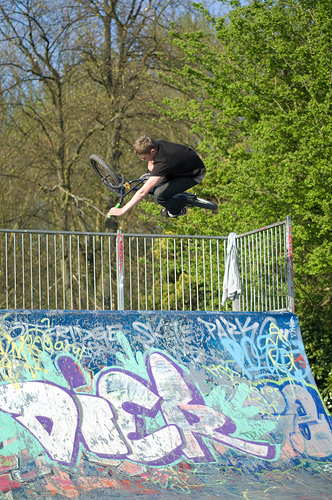

In [ ]:
print (f'''
    Score для изображения {test_preds_df['score'].iloc[query_idx]}
    Текст предсказания {test_queries.iloc[query_idx]['query_text']}''')

# найдем изображение
img_name = test_data['image'].iloc[img_idx]

# достаем путь к изображению в переменной test_images
img_path = [img for img in test_images if img.name == img_name]

# открываем
Image.open(img_path[0])

**Отобразим больше изображений**

In [ ]:
# index предсказания отсортированного по убывани скора
query_idx_sort = test_preds_df.sort_values(ascending = False, by = 'score')['query_idx'].to_list()
query_idx_sort[:10]


[51, 364, 156, 243, 305, 418, 354, 48, 158, 99]

In [ ]:
test_preds_df

,query_idx,img_idx,score
0,0,1,0.199504
1,1,23,0.210581
2,2,49,0.210854
3,3,49,0.210915
4,4,69,0.205833
...,...,...,...
495,495,71,0.227619
496,496,76,0.232716
497,497,71,0.227629
498,498,71,0.227621


In [ ]:
# индекс изобажения отсортированного по убывани скора соответствующие запросам
test_img_idx_sort = test_preds_df['img_idx'].iloc[query_idx_sort].to_list()
test_img_idx_sort[:10]

[63, 63, 46, 63, 63, 46, 43, 43, 63, 63]

In [ ]:
# название изображения для отсортированного списка
test_img_name_sort = test_data['image'].iloc[test_img_idx_sort].to_list()
test_img_name_sort[:10]

['191003283_992257f835.jpg',
 '191003283_992257f835.jpg',
 '3351418768_596ef7fd6f.jpg',
 '191003283_992257f835.jpg',
 '191003283_992257f835.jpg',
 '3351418768_596ef7fd6f.jpg',
 '3459871361_92d1ecda36.jpg',
 '3459871361_92d1ecda36.jpg',
 '191003283_992257f835.jpg',
 '191003283_992257f835.jpg']

In [ ]:
# сохраняем путь до изображений для отображения
show_img = []

for img_name in test_img_name_sort:
    for img_path in test_images:
        if img_path.name == img_name:
             show_img.append(img_path)
print (len(show_img))

500


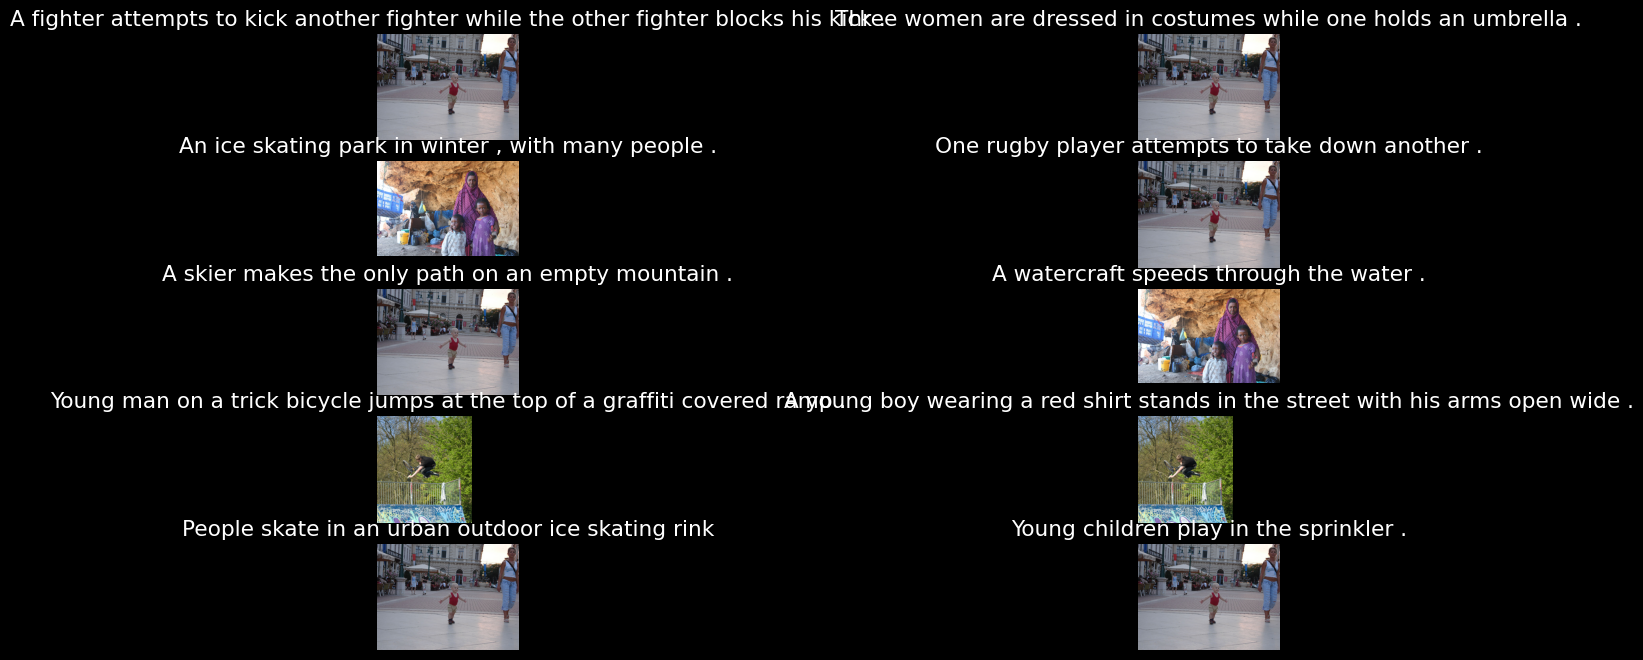

In [ ]:
# строим график
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize= (18, 8), sharey=True, sharex=True)
plt.subplots_adjust(hspace =.2, wspace = 0.2)

for i, ax_i in enumerate(ax.flatten()):
    # открываем
    img = Image.open(show_img[:10][i])

    # выводим на экран
    ax_i.imshow(img)
    ax_i.axis('off')
    ax_i.set_title(test_queries['query_text'].iloc[query_idx_sort[i]])  # текст предсказания

plt.show()

Видим что изображения и описания совсем не совпадают. Возможно это связано с тем что в тестовой выборке имеются запросы для изображения детей, а модель их не видела

### Функция тестирования

Напишем функцию для обработкки запросов фото по описанию. Фуункция будет принимать 1 описание, проверять его на соответствие требованиям законодательства о защите информации связанной с детьми и в случае если в запросе отстутствют запрещенные слова то функция вернет изображен с максимальным скором.


In [ ]:
def is_permitted(query):
    for items in blacklist:
        if items in query:
            return "УПС..Такое нельзя показывать"


In [ ]:
test_queries['query_text'][0]

'Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .'

In [ ]:
def checking_if_present(query_text):
    for idx in range(len(test_queries)):
        if test_queries['query_text'][idx] == query_text:
            return idx
    return 'Подходящее изображение не найдено'

In [ ]:
query = 'Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .'

In [ ]:
# проверяем
query_idx = checking_if_present(query)
query_idx

0

In [ ]:
img_idx = test_preds_df['img_idx'].iloc[query_idx]


    Score для изображения 0.19950361421672622
    Текст предсказания Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .


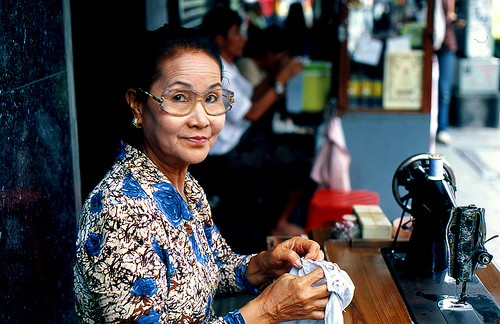

In [ ]:
print (f'''
    Score для изображения {test_preds_df['score'].iloc[query_idx]}
    Текст предсказания {test_queries.iloc[query_idx]['query_text']}''')

# найдем изображение
img_name = test_data['image'].iloc[img_idx]

# достаем путь к изображению в переменной test_images
img_path = [img for img in test_images if img.name == img_name]

# открываем
Image.open(img_path[0])

In [ ]:
test_preds_df['img_idx'].value_counts()

img_idx
52    124
71    121
63    108
76     25
49     21
69     21
72     21
1      20
99      7
46      6
23      6
48      5
14      5
79      3
60      2
43      2
81      1
98      1
88      1
Name: count, dtype: int64

In [ ]:
# объединяем все шаги
def process_and_check_query(query):

    def is_permitted(query):
        for item in blacklist:
            if item in query:
                return "УПС.. Такое нельзя показывать"

    if is_permitted(query):
        return "Запрос содержит недопустимые элементы"

    def checking_if_present(query):
        for idx in range(len(test_queries['query_text'])):
            if test_queries['query_text'].iloc[idx] == query:
                return idx
        return 'Подходящее изображение не найдено'

    query_idx = checking_if_present(query)
    if query_idx == 'Подходящее изображение не найдено':
        return query_idx

    img_idx = test_preds_df['img_idx'].iloc[query_idx]

    try:
        score = test_preds_df['score'].iloc[query_idx]
    except:
        score = query_idx

    result_info = f'''
        Score для изображения {score}
        Текст предсказания {test_queries.iloc[query_idx]['query_text']}'''

# ...

    img_name = test_data['image'].iloc[img_idx]

    # Достаем путь к изображению в переменной test_images
    img_path = [img for img in test_images if img.name == img_name]

    print("img_name:", img_name)
    print("img_path:", img_path)

    return result_info, img_path

In [ ]:
# Проверка
rnd_idx = np.random.choice(test_queries['query_text'].index)
query_text = test_queries['query_text'][rnd_idx]

result = process_and_check_query(query_text)
if isinstance(result, tuple) and len(result) == 2:

    result_info, img_path = result
    print(result_info)

else:
    print(result)


img_name: 2461990494_c5ece064cc.jpg
img_path: [PosixPath('/kaggle/working/to_upload/test_images/2461990494_c5ece064cc.jpg')]

        Score для изображения 0.23265382861903933
        Текст предсказания People are watching a race car speed thorugh the dirt .


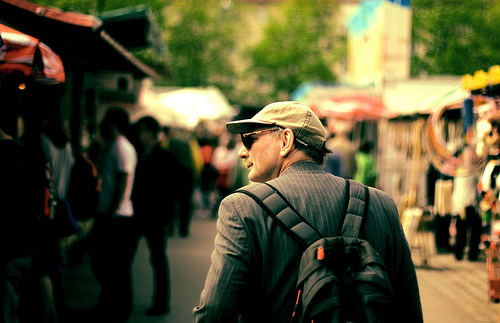

In [ ]:
Image.open(img_path[0])

# Вывод

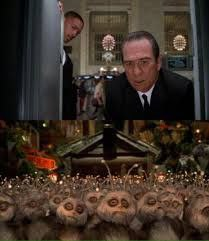


Для анализа возможности получения изображения по описанию мной были проанализированы имеющиеся данные и принято решение использовать только объекты, имеющиеся в  датасете train_data, a целевой признак получить из experts_annotations.
Этот подход, возможно, не дал в полной мере найти все закономерности, так как я соединила данные методом inner, что означает использование исключительно тех данных, для которых совпадают image(название  изображения по которому его можно найти в папке с изображениями) и id текстового описания.
В качестве целевого признака я использовала усредненную оценку трех экспертов, привиденную к диапазону 0-1 функцией sigmoid.


Я  получила эмбеддинги векторов описания и изображений.

Итоговый датасет для обучения включал в себя
- Итоговый датафрейм содержит 4228 объектов
- 2082 признаков
- 2048 это развернутый эмбеддинг изображений
- 33 признака развернутого эмбеддинга описания
- целевой признак avg


Для получения подзодящего под описание фотографий были проанализированы следующие модели:

- KNeighborsRegressor на параметрах n_neighbors = 10, weight = distance
- KNeighborsRegressor
- Нейронная сеть с 5 линейными слоями с функцией активацией Relu
Для оценки моделей я использовала метрику rmse.

|модель|train метрика| val метрика|
|------|-------------|------------|
|KNeighborsRegressor |   0.007    |
|Нейронная сеть      |    0.09    |

Таким образом Все модели достигли адекватного значения метрики, и все можно использовать в финнальной части.

Все модели обучаются одинаково быстро. Учитывая это, в качестве лучшей модели.

Но, несмотря на то, что модели показали хороший результат на валидационной выборке на тестовой он оказался неудовлетворительным.

Так, на валидационной выборке максимальный score для пары описание-изображение достигал 0.93, а на тестовой 0.84.
Эти оценки соотносятся с исходными следующим образом:
- средняя оценка 0.73 соответствует объектам где 3 эксперта сообщили о полном несоответствии объекта описанию.
- средняя оценка 0.982 соответствует объектам где 3 эксперта сообщили о полном соответствии объекта описанию.

Что, Учитывая масштабирование нашего целевого признака очень низкий результат, то есть из 50000 возможных комбинаций модель была уверена на 2 балла из 4, то есть 50/50 если перевести на язык классификации.

Это может быть связано с тем что
1. В обучающем датасете отсутствовали объекты, которые включают в себя слово, которое явно описывает несовершеннолетних людей (blacklist)
2. Другая причина может быть в том, что могла произойти утечка данных:
валидационная выборка была использована в обеих моделях в knn для кроссвалидации, а в нейронной сети на ней валидировались эпохи.
3. Возможно, модели переобучились и перетренировались на имеющихся объектах

После того, как я получила все 50000 тысяч предсказаний я сохранила датасет в котором для каждого query_id был представлен максимальный score.

Далее создана функция
def process_and_check_query(query_text)

Которая принимает на вход 1 описание, проверяет его на соответствие требованиям законодательства о защите информации связанной с детьми и в случае если в запросе отстутствуют запрещенные слова, то функция вернет путь до иэтого изображения, его score и описание.


Вывод: в таком виде модель использовать нельзя